## Week 7 Video Notebook: Ensemble Methods -- Bagging

In [9]:
# Useful imports and utilities

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV,LeaveOneOut 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from tqdm import tqdm

# globals

random_state = 42

# utility code

def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

# To avoid constant warnings about jobs: 
#        UserWarning: A worker stopped while some jobs were given to the executor. 
#        This can be caused by a too short worker timeout or by a memory leak.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


### Load and Split the CA Housing Dataset

In [10]:
# Load the California Housing Dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


# X.info()

In [11]:
# Split dataset 

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


len(X_train),len(X_test)

(16512, 4128)

## Exploration and Tuning of Parameters by Hand

### Basic Bagging Regressor

We provide a wrapper function to simplify experimentation with parameters. We will use cross-validation to find the validation score for each choice of parameters.  

Note: See the **Appendix** below for a detailed description of the parameters and suggestions for how to use them. 


In [12]:
# Wrapper around BaggingRegressor with cross-validation

# Note on n_jobs:  There are two parallel threads here, for the model and the CV. Depending on
# your machine, so you may have to run everything with n_jobs = 1, or run one with -1 and one
# with 1. This configuration runs well on my Macbook Pro with M4 chip, but YMMV.

# If it still runs too slow, you could try changing the default for cv to 3. 

# record beginning time
start = time.time()

### Bagging Regressor ###
def run_bagging_regressor(X_train,
                             y_train,
                             estimator    = DecisionTreeRegressor(), # defaults
                             n_estimators = 10,
                             max_samples  = 1.0, 
                             max_features = 1.0,
                             random_state = random_state,
                             cv=5,         # Number of folds for cross-validation
                             n_jobs = -1   
                            ):                
    
    bagging_model = BaggingRegressor(
        estimator    = estimator,
        n_estimators = n_estimators, 
        max_samples  = max_samples,
        max_features = max_features,
        n_jobs       = n_jobs,       
        random_state = random_state
    )

    # Perform cross-validation and return mean CV MSE
    neg_mse_scores = cross_val_score(bagging_model, X_train, y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=cv, 
                                     n_jobs=n_jobs
                                    )
    mean_cv_mse = -np.mean(neg_mse_scores)             # Convert negative MSE back to positive
    
    return mean_cv_mse

# Baseline using defaults
baseline_mse = run_bagging_regressor(X_train, y_train,n_jobs=-1)   
                                                                    
print(f'Baseline MSE: {baseline_mse:.4f}')

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))


Baseline MSE: 0.2883
Execution Time: 2.26s


### Exploring Parameter Choices

#### Single experiments are often useful....

In [14]:
run_bagging_regressor(X_train,y_train,estimator=LinearRegression())

0.521293409181168

In [28]:
run_bagging_regressor(X_train,y_train,estimator=SVR())

1.3780857982829091

In [27]:
run_bagging_regressor(X_train,y_train,n_estimators=10,max_samples=1.0,max_features=8)

0.2882906603831777

### Your Turn!

Pause the video and cut and paste the function call from the last cell, and try various values of the parameters. 

#### But visualizing the relationships is better!

### Plotting Parameter Choices against MSE

100%|███████████████████████████████████████████| 96/96 [15:57<00:00,  9.98s/it]


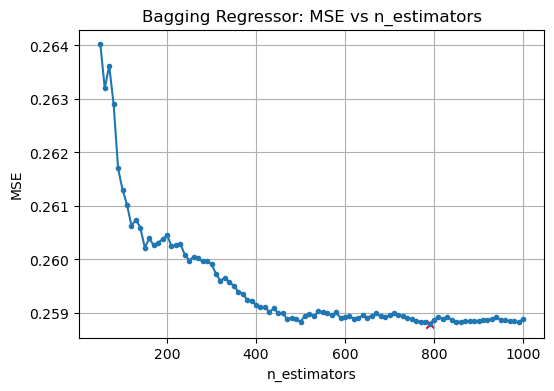

Minimum MSE 0.2588 found at x = 790
Execution Time: 15m 57.75s


In [38]:
# Plot a n_estimators vs MSE using a simple for loop

# record beginning time
start = time.time()

parameter_list = range(50,1001,10)       

param = 'n_estimators'                  # <= and here

MSEs = []

for n in tqdm(parameter_list):

    MSEs.append( run_bagging_regressor(X_train,y_train,
                                       n_estimators = n,                  #  <= and here
                                       max_samples  = 1.0,
                                       max_features = 1.0   
                                      ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|█████████████████████████████████████████████| 8/8 [01:13<00:00,  9.24s/it]


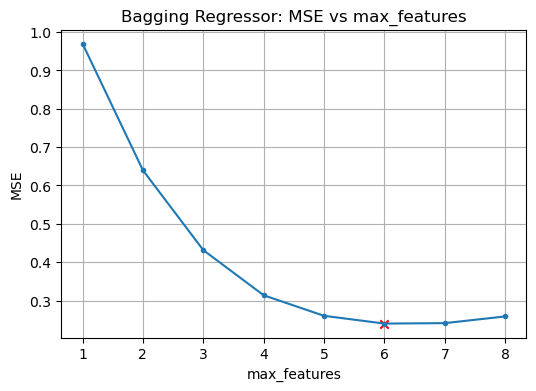

Minimum MSE 0.2402 found at x = 6
Execution Time: 1m 14.00s


In [33]:
# Plot a max_features vs MSE using optimal value for n_estimators=790 

# Note: there are 8 features, so more useful to use integers

start = time.time()

parameter_list = range(1,9)                   # <= Make changes here:   

param = 'max_features'                        # <= and here

MSEs = []

for n in tqdm(parameter_list):

    MSEs.append( run_bagging_regressor(X_train,y_train,
                                       n_estimators = 790,                  # <= and here
                                       max_samples  = 1.0,
                                       max_features = n
                                      ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 11/11 [01:44<00:00,  9.54s/it]


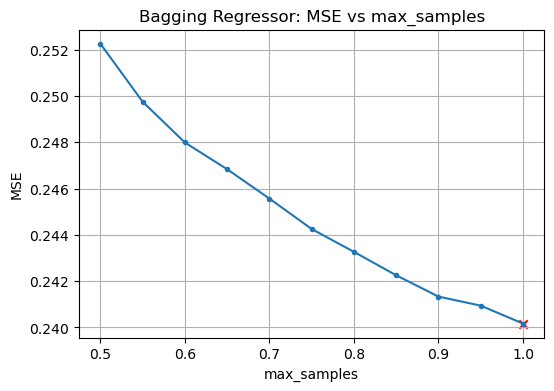

Minimum MSE 0.2402 found at x = 1.0000
Execution Time: 1m 45.01s


In [37]:
# Plot a max_samples vs MSE using a simple for loop using n_estimators = 790 and max_features = 6

# Note: Since there are 16,512 training samples, use float to specify percentage of total

start = time.time()

# parameter_list = np.linspace(0.1,1.0,10)       # <= Make changes here: 
parameter_list = np.linspace(0.5,1.0,11)

param = 'max_samples'                          # <= and here

MSEs = []

for n in tqdm(parameter_list):

    MSEs.append( run_bagging_regressor(X_train,y_train,
                                       n_estimators = 790,
                                       max_samples  = n,
                                       max_features = 6
                                      ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [15]:
run_bagging_regressor(X_train,y_train,n_estimators=790,max_samples=1.0,max_features=6)

0.24008960920962882

#### If all the parameters were independent, then we would be done!  But of course it's not that simple....

### Second Round:  Redo the experiments with optimal values to refine

100%|█████████████████████████████████████████| 101/101 [03:55<00:00,  2.33s/it]


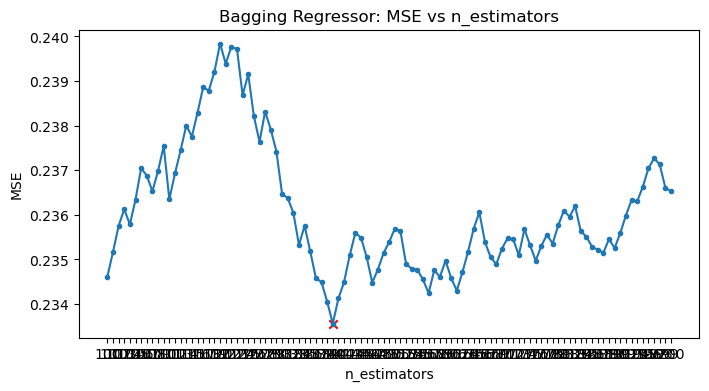

Minimum MSE 0.2336 found at x = 140
Execution Time: 3m 55.94s


In [39]:
# Plot n_estimators vs MSE with max_samples = 1.0 and max_features = 6

start = time.time()

# parameter_list = range(50,1001,10)        # I ran this and got 140, see plot below
parameter_list = range(100,201)             # So ran it with maximum precision (these are integers)

param = 'n_estimators'                

MSEs = []

for n in tqdm(parameter_list):

    MSEs.append( run_bagging_regressor(X_train,y_train,
                                       n_estimators = n,
                                       max_samples  = 1.0,
                                       max_features = 6                                  
                                      ) ) 

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(8, 4))
plt.title("Bagging Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.xticks(parameter_list)
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

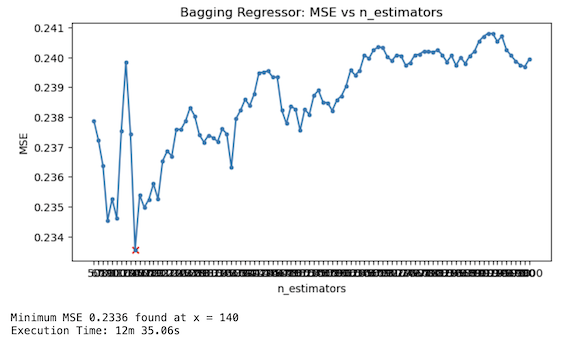

### Your Turn!

Rerun the tests for `max_samples` and `max_features` by cutting and pasting from the cells above and making the appropriate changes. 

Hint: You'll very likely get a value very close but not equal to 1.0 for `max_samples`.  Given the randomness involved in splitting the data, choosing 6 out of 8 features, and doing CV, it is not necessary to worry about very small differences in this parameter, which refers to a percentage of 16,512 samples. 

**Realizing when you have reached the "point of diminishing returns" is one of the skills you need to learn in training machine learning models.** 

In [17]:
run_bagging_regressor(X_train,y_train,n_estimators=140,max_samples=1.0,max_features=6)

0.23378707705066587

In [23]:
run_bagging_regressor(X_train,y_train,n_estimators=140,max_samples=0.998,max_features=6)

0.2336620983658512

### How Accurately can we Tune Parameters?

As usual, the answer is "It depends"!

The most important thing to realize is that if we want our model to **GENERALIZE** to **new data** then we can not depend on a particular split of the data. 

Here is a histogram of the MSEs that result from these "optimal" parameters if we run it with 100 different random states, representing 100 different random splits of the data. I did not change the random state of the model or the CV, so any variation you see is due completely to what split of training and testing data occurs. 

The variance of your predictions from the trained model is of course an important consideration, so we shall continue to think about this in the other ensemble models. 

Note: One way to reduce the variance is to use `cv=LeaveOneOut()` in the CV scoring, however it is horribly inefficient for large data sets, and I don't use it unless I want to run the program all night long!

100%|█████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


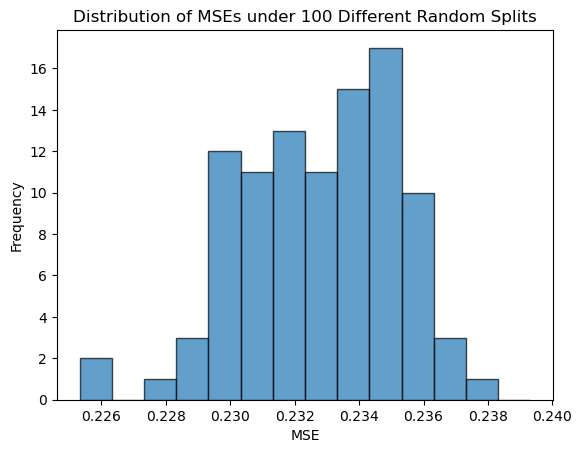

Mean MSE: 0.2329
Std MSE: 0.0025


In [75]:
# calculate MSE with "optimal" parameters and different random splits of the data

random_states = np.random.choice(range(1, 10000), size=100, replace=False)

MSEs = []
                                 
for rs in tqdm(random_states):
                                 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

    MSEs.append( run_bagging_regressor(X_train,y_train,
                                       n_estimators=140,
                                       max_samples=1.0,
                                       max_features=6)
               )

# histogram of MSEs

bin_spacing = np.arange(min(MSEs),max(MSEs),0.001)

plt.title("Distribution of MSEs under 100 Different Random Splits")
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.hist(MSEs,edgecolor='black',bins=bin_spacing,alpha=0.7)
plt.show()

print(f"Mean MSE: {np.mean(MSEs):.4f}")
print(f"Std MSE: {np.std(MSEs):.4f}")

### [Disgression: Multiple Plots can Illustrate the Relationships between Parameters]

If we do multiple plots, we can show the effect of one parameter on another in a very useful way!

**Remember: One of your goals is to UNDERSTAND your data, and seeing plots together is an excellent way to understand what is going on.**

max_features=8: 100%|███████████████████████████| 21/21 [00:58<00:00,  2.78s/it]


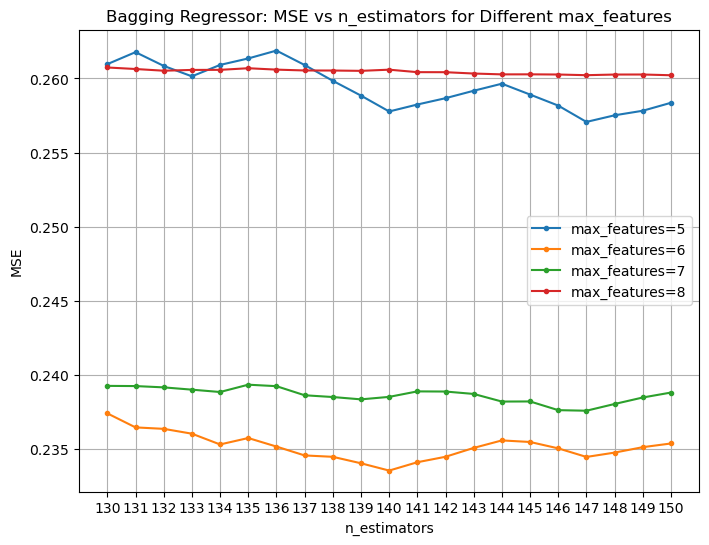

In [44]:
# Multiple plot of n_estimators vs MSE for various values for max_features


# Parameter values for n_estimators and max_features
parameter_list = range(130, 151)  # Range of n_estimators
max_features_list = range(5,9)  # Values for max_features

# Initialize the plot
plt.figure(figsize=(8, 6))
plt.title("Bagging Regressor: MSE vs n_estimators for Different max_features")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.xticks(parameter_list)
plt.grid()

# Loop through each value of max_features
for mf in max_features_list:
    MSEs = []  # Store MSEs for each n_estimators
    
    # Run for each n_estimators value
    for n in tqdm(parameter_list, desc=f"max_features={mf}"):
        MSEs.append(run_bagging_regressor(
            X_train,y_train,
            n_estimators=n,
            max_features=mf,
            max_samples = 1.0
        ))
    
    # Plot results for this max_features value
    plt.plot(parameter_list, MSEs, marker='.', label=f"max_features={mf}")

# Add legend to distinguish lines for each max_features
plt.legend()
plt.show()


### [End of Digression]

## Exploration and Tuning of Parameters using Grid Search and Random Search

#### Is there a better way than "rolling your own" tuning code with `for` loops?

Ideally, after exploring the data and basic parameter relationships with "hand tuning," in the end it would be useful to have a systematic method for searching the space of all parameter values, something like gradient search for hyperparameters. 

In general, I like to see visual displays to understand the data and the search space, using the code such as I have demonstrated above, and then use use grid search to confirm and refine my results.  It is fairly inefficient, so don't use it to explore large numbers of possibilities. You can run grid search multiple times with narrower and narrower parameter ranges, similar to what we did above explicitly with for loops. 


`GridSearchCV` will allow you to specify a list of parameter values, and it will test every combination.
It will use cross-validation and give you a list of the best parameter settings.  If it takes too long, you can reduce the number of folds in CV or, at the loss of some accuracy, try using `RandomizedSearchCV`, which is included in the code but commented out. 





In [84]:
# Run GridSearchCV

# Record start time
start = time.time()

# Define the model
bagging_model = BaggingRegressor(random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators': range(138,143),                 # Note that I have used relatively few options
    'max_samples' : np.linspace(0.99,1.0,11),
    'max_features': [6]
}

# Use GridSearchCV to find the best parameters

search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=5,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Or RandomizedSearchCV -- not as accurate but faster

# search = RandomizedSearchCV(
#     estimator=bagging_model,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of random combinations to test
#     scoring='neg_mean_squared_error',  # MSE but negated for maximization by RandomizedSearchCV
#     cv=5,  # Number of folds for cross-validation
#     n_jobs=-1,  # Use all available cores
#     random_state=random_state
# )

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_max_samples',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_max_samples': 'max_samples',
        'param_max_features': 'max_features',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")

# Evaluate on the test set
y_pred_bagging = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_bagging)

print(f"Test MSE:    {test_mse:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))


Search Results (Top 5):

 n_estimators  max_samples  max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          140        0.998             6       0.235719      0.006542          0.032923         0.000324
          140        0.999             6       0.235778      0.006562          0.032839         0.000405
          140        1.000             6       0.235819      0.006584          0.032725         0.000435
          140        0.996             6       0.235854      0.006247          0.033121         0.000432
          140        0.995             6       0.236280      0.006274          0.033224         0.000416

Best Parameters: {'max_features': 6, 'max_samples': 0.998, 'n_estimators': 140}
Best CV MSE: 0.2357
Test MSE:    0.2114
Execution Time: 2m 7.65s


### Your Turn!

Rerun the previous cell after commenting-out `GridSearchCV` and commenting-in `RandomSearchCV`. 
Compare the accuracy of the results compared with the exhausive grid search, and also the amount of time it takes!    (Another tradeoff!)

### Completely Optional but Worth Considering

We did not manipulate any of the parameters of `DecisionTreeRegressor` in any of our tuning, and so the trees are able to grow to any depth.  In particular, you might try `friedman_mse` over `square_error` and try limiting the depth of the trees. 

## **Appendix**

### **Best Practices for `BaggingRegressor`**

The following is a list of the most useful parameters and guidance about how to adjust them. For a full list of parameters, see the `sklearn` documentation. 

Note that for some parameters (e.g., 'max_features') you can use an int or a float, the latter representing the percentage of the number of choice. Except for very simple datasets, it is usual to use floats, for example, `max_samples = 0.66` would train each estimator on approximately 2/3s of the data points. 

---

- **`estimator`** (default=`DecisionTreeRegressor`)  
  The base estimator used to fit on random subsets of the dataset.  
  - **Best Practices**:  
    - Use tree-based models (e.g., `DecisionTreeRegressor`) for capturing non-linear and complex patterns without feature transformations.  
    - For linear relationships, try linear models (e.g., `LinearRegression`, `Ridge`), with Bagging stabilizing performance in noisy data.  
    - Use `SVR` for datasets with mixed linear and non-linear relationships, particularly in high-dimensional data, as Bagging can help reduce overfitting risks.

---

- **`n_estimators`** (int), default=10  
  The number of base estimators in the ensemble.  
  - **Best Practices**:  
    - Start with the default and increase as long as you see improvement.
    - Evaluate diminishing returns by plotting the error as a function of `n_estimators`.

---

- **`max_depth`** {None, int}, default=None 
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain fewer than `min_samples_split` samples.  
  - **Best Practices:**
      - Set a reasonable value for `max_depth` (e.g., 10-20) to prevent overfitting, especially on small datasets.
      - Use **grid search** or **cross-validation** to identify the optimal depth for your dataset.
      - If you expect simple relationships in your data, consider a shallower tree for better generalization.

---

- **`max_samples`** (int or float), default=1.0  
  The number of samples to draw from the training data to train each base estimator. Samples are drawn with replacement by default.  
  - **Best Practices**:  
    - The default (`1.0`, i.e., 100%) works well for many datasets.  
    - For large datasets or when overfitting occurs, experiment with lower values (e.g., 0.66) to introduce more randomness.

---

- **`max_features`** (int, float, or None), default=1.0  
  The number of features to draw from the dataset to train each base estimator. Features are drawn without replacement by default.  
  - **Best Practices**:  
    - For high-dimensional datasets, reduce `max_features` (e.g., 0.5) to speed up training and introduce diversity across models.  
    - The default (1.0) works well for smaller datasets or when feature diversity is not a concern.

---

- **`n_jobs`** (int), default=1 
  The number of jobs (CPU cores) to run in parallel for both training and prediction. If `n_jobs=-1`, all available CPU cores will be used.  
  - **Best Practices**:  
    - Set `n_jobs=-1` to maximize parallel processing and speed up training, especially for large datasets or when using a high number of estimators (`n_estimators`).  
    - For shared or resource-limited environments, specify a smaller number (e.g., `n_jobs=2`) to avoid overloading the system.  
    - Use the default (1) for small datasets or when parallelization is not a concern.  
  - **Note**: Be cautious of memory usage when parallelizing on very large datasets, as each job holds a copy of the data in memory.
  

---

